# **Lab 1**

## **Data Extraction**

In [120]:
# Setup
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings 
warnings.simplefilter(action = 'ignore')

In [121]:
# Transform .dat file to .csv
for file in ["NACA0012_25Hz_70pitch", "NACA4412_25Hz_70pitch"]:
    datContent = []
    for i in open(file + ".dat").readlines():
        if str(i[0]) in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "-"]:
            datContent.append(i.strip().split())

    with open(file + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(datContent)

In [122]:
# Transform .csv to DataFrames

naca0012_data = {}
naca4412_data = {}

for file in ["NACA0012_25Hz_70pitch", "NACA4412_25Hz_70pitch"]:

    if file == "NACA0012_25Hz_70pitch":
        storage = naca0012_data
    elif file == "NACA4412_25Hz_70pitch":
        storage = naca4412_data

    df_composite = pd.read_csv(file + ".csv", index_col = 0, header = None, names = ["Dyn. Pressure (In. H20)", "Surf. Pressure (In. H20)"])

    # Break each airfoil's data into data for each AoA
    chunk_size = 19
    num_chunks = int(len(df_composite.index) / 19)

    for i in range(num_chunks):
        chunk_old = df_composite.iloc[chunk_size * i:chunk_size * (i+1)]
        chunk = chunk_old.iloc[1:, :]
        chunk.name = int(chunk_old.index[0])

        storage[chunk.name] = chunk

In [123]:
# Correcting pressure tap 17 for NACA4412

port_17 = pd.DataFrame(data = {'AoA': [0, 4, 6, 8, 10, 12, 14], 'Dynamic': [2.557, 2.614, 2.626, 2.644, 2.655, 2.654, 2.653], 'Static': [-0.193, 0.948, 1.117, 1.337, 1.451, 1.526, 1.580]})
i = 0
for item in naca4412_data:
    tbl = naca4412_data[item]
    tbl.loc[17][0] = port_17.iloc[i][1]
    tbl.loc[17][1] = port_17.iloc[i][2]
    naca4412_data[item] = tbl
    i += 1

In [124]:
# Plotting airfoils

#https://en.wikipedia.org/wiki/NACA_airfoil#Equation_for_a_cambered_4-digit_NACA_airfoil
def camber_line( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    m * (x / np.power(p,2)) * (2.0 * p - (x / c)),
                    m * ((c - x) / np.power(1-p,2)) * (1.0 + (x / c) - 2.0 * p ))

def dyc_over_dx( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    ((2.0 * m) / np.power(p,2)) * (p - x / c),
                    ((2.0 * m ) / np.power(1-p,2)) * (p - x / c ))

def thickness( x, t, c ):
    term1 =  0.2969 * (np.sqrt(x/c))
    term2 = -0.1260 * (x/c)
    term3 = -0.3516 * np.power(x/c,2)
    term4 =  0.2843 * np.power(x/c,3)
    term5 = -0.1015 * np.power(x/c,4)
    return 5 * t * c * (term1 + term2 + term3 + term4 + term5)

def naca4(x, m, p, t, c=1):
    dyc_dx = dyc_over_dx(x, m, p, c)
    th = np.arctan(dyc_dx)
    yt = thickness(x, t, c)
    yc = camber_line(x, m, p, c)  
    return ((x - yt*np.sin(th), yc + yt*np.cos(th)), 
            (x + yt*np.sin(th), yc - yt*np.cos(th)))

(-0.05, 1.05)

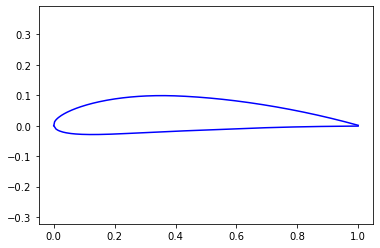

In [125]:
# NACA 4412
x = np.linspace(0,1,200)
for item in naca4(x, .04, .4, .12, 1):
    plt.plot(item[0], item[1], 'b')

plt.axis('equal')
plt.xlim((-0.05, 1.05))

(-0.05, 1.05)

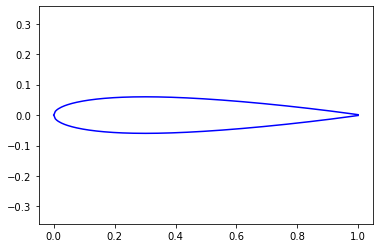

In [126]:
# NACA 0012
x = np.linspace(0,1,200)
for item in naca4(x, 0, 0.00001, .12, 1):
    plt.plot(item[0], item[1], 'b')

plt.axis('equal')
plt.xlim((-0.05, 1.05))

In [127]:
# Airfoil geometry

naca0012_shape = pd.DataFrame(data = {
    'Tap': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
})

## **Task 1**

In [128]:
# Calculating U, Re, Cp

U_naca0012 = 33.3 # m/s
U_naca4412 = 34.0 # m/s

chord = .1524 # m [6 in]

p_atm = 98700 # Pa [29.15 in Hg]
T_atm = 300.93 # K [82 F, 27.78 C]
rho = 1.14486 # kg/m3 [at given p_atm and t_atm]
mu = 18.5 * 10**-6 # Pa*s

re_naca0012 = rho * U_naca0012 * chord / mu
re_naca4412 = rho * U_naca4412 * chord / mu

for item in naca0012_data:
    tbl = naca0012_data[item]
    tbl["Cp"] = ((pd.to_numeric(tbl["Surf. Pressure (In. H20)"]) * 249.08) - p_atm) / (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]) * 249.08)
    tbl["U"] = (2 * (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]) * 249.08) / rho) ** .5
    naca0012_data[item] = tbl

for item in naca4412_data:
    tbl = naca4412_data[item]
    tbl["Cp"] = ((pd.to_numeric(tbl["Surf. Pressure (In. H20)"]) * 249.08) - p_atm) / (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]) * 249.08)
    tbl["U"] = (2 * (pd.to_numeric(tbl["Dyn. Pressure (In. H20)"]) * 249.08) / rho) ** .5
    naca4412_data[item] = tbl

In [129]:
naca0012_data[0]

,Dyn. Pressure (In. H20),Surf. Pressure (In. H20),Cp,U
1.0,2.505,1.390,-157.632028,33.015061
2.0,2.505,-1.056,-158.608475,33.015061
3.0,2.510,-0.967,-158.257064,33.047993
4.0,2.509,-0.878,-158.284667,33.041410
5.0,2.507,-0.822,-158.388604,33.028238
6.0,2.506,-0.771,-158.431457,33.021650
7.0,2.512,-0.713,-158.029948,33.061157
8.0,2.511,-0.638,-158.063015,33.054576
9.0,2.509,-0.573,-158.163105,33.041410
10.0,2.508,-0.510,-158.201049,33.034824


## **Task 2**

#### **2A**

#### **2B**